# Playground

Welcome to the Playground! I made this notebook to play around while completing the convolutional neural network algorithm from scratch.<br> 
I recommend you to also play around with this notebook to understand how the algorithm works. Feel free to experiment by changing the codes.
<br><br>
This notebook is based on:
- https://victorzhou.com/blog/intro-to-cnns-part-1/
- https://victorzhou.com/blog/intro-to-cnns-part-2/<br>
<br>Have a look at these links for more details

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Let's use a simple MNIST handwritten digits dataset. Tensorflow has mnist dataset built in the library, just import them and it will automatically split the data into train and test set.

In [2]:
#let's use simple data with mnist digits
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

MNIST dataset is a grayscale image, which means it has only 1 color channel for each image unlike images in general with 3 color channels (RGB)

In [3]:
x_train[0].shape

(28, 28)

Let's see the first image inside the training set

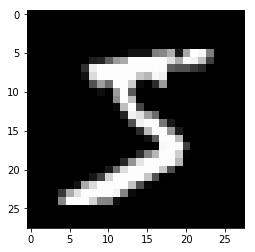

In [4]:
plt.imshow(x_train[0], cmap='gray')

In [5]:
y_train[0]

5

Keep in mind that we are trying to train these handwritten digits

In [6]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

## Part 1 - Convolutional2D

This is the main core of the algorithm itself. Convolutional operation is very similar to matrix multiplication. It involves an nxn kernel/filter, then it convolves with a group of nxn pixel image until the end of the image.

![ConvolutionalURL](https://media.giphy.com/media/i4NjAwytgIRDW/giphy.gif "convolutional operation")

To simplify things, let's assume that we use only 3x3 filters along with 1 stride and no padding

In [7]:
class Convolution2D:
    def __init__(self, filter_shape, num_filters):
        self.filter_shape = filter_shape
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, filter_shape[0], filter_shape[0]) # random initialization
        
    def iterate(self, img, filter_shape):
        height, width = img.shape
        
        for i in range(height - 2):
            for j in range(width - 2):
                output = img[i:(i+filter_shape[0]), j:(j+filter_shape[0])]
                yield output, i, j # 'yield' keyword will return any values and continue from the last value returned
    
    def conv2d(self, inputs):
        height, width = inputs.shape
        output = np.zeros((height-2, width-2, self.num_filters)) 
        
        for region, i, j in self.iterate(inputs, self.filter_shape):
            output[i, j] = np.sum(region * self.filters, axis=(1,2))
#             print(region.shape)
#             print(self.filters.shape)
#             print(region * self.filters)
        
        return output

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

convolution = Convolution2D(filter_shape=(3,3), num_filters=8)
output = convolution.conv2d(x_train[0]) # x_train = 28x28 shape
output.shape # output should be 26x26 because of the convolution computation

(26, 26, 8)

Notice that the shape of the image "shrinks" after the convolutional operation. Later, we will learn about <b>padding</b> and how does it solves this shrinking problem

## Part 2 - Maxpool2D

Pooling layers are also commonly used in the CNN. Here, we use the maxpooling layer. There are many types of pooling layer apart from maxpool for example: average pooling, min pooling, global pooling, etc. <b>This layer functions as a "filter" to eliminate adjacent pixel images which have similar values (since they share the same information and it becomes redundant) </b>

![MaxPoolURL](https://thumbs.gfycat.com/FirstMediumDalmatian-size_restricted.gif "2x2 MaxPool")
image taken from: https://gfycat.com/firstmediumdalmatian

Again to simplify things, let's assume we use 2x2 maxpool with 1 stride

In [9]:
class MaxPool2D:
    def iterate(self, img):
        height, width, _ = img.shape
        h = height//2
        w = width//2
        
        for i in range(h):
            for j in range(w):
                new_region = img[(i*2):(i*2+2), (j*2):(j*2+2)]
                yield new_region, i, j
    
    # 2x2 maxpool
    def pool(self, inputs):
        height, width, num_filters = inputs.shape
        output = np.zeros((height//2, width//2, num_filters))
        
        for img_region, i, j in self.iterate(inputs):
            output[i, j] = np.max(img_region, axis=(0,1))
        
        return output

In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

convolution = Convolution2D(filter_shape=(3,3), num_filters=8)
maxpool = MaxPool2D()

output = convolution.conv2d(x_train[0]) # x_train = 28x28 shape
output = maxpool.pool(output) # 26x26x8 before pooling
output.shape # should be 13x13x8 after pooling

(13, 13, 8)

Image dimension will halve after the pooling operation

## Part 3 - Dense Layer

Now we get to the neural network part. Remember that we are trying to classify 10 different classes of handwritten digits. So, this <b> is not a binary classification problem</b> instead, this is a <b> multiclassification problem</b>. In CNN, we call it Softmax layer which is a fully connected layer with a softmax function

![DenseURL](https://miro.medium.com/max/2808/1*SGPGG7oeSvVlV5sOSQ2iZw.png "Fully connected layer")
image taken from: https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9

Take a look at the last maxpooling layer. The image has 3 dimensions (height x width x channel) while neural network requires us to have a 2D (nx1) vector image. Finally, the last layer will be connected with 10 different nodes with its probabilities for each number.

In [11]:
class Softmax:
    # initialize random weights and zero biases
    def __init__(self, num_features, num_nodes):
        self.weights = np.random.randn(num_features, num_nodes) / num_features
        self.biases = np.zeros(num_nodes)
#         print(self.weights.shape)
#         print(self.biases.shape)
    
    # flattens out the previous layer to nx1 vector
    def flatten(self, inputs):
        self.inputs = inputs.flatten()
#         print(self.inputs.shape)
    
    # connects flattened layer with a fully connected layer (dense)
    def dense(self, inputs):
        input_features, nodes = self.weights.shape
        
        z = np.dot(self.inputs, self.weights) + self.biases # z = W . X + b
        a = np.exp(z) # a = g(z)

        return a / np.sum(a, axis=0) # e^a / sum(a)

Now you might ask: <b>Why we have to convert these outputs into probabilities? Why we have to bother with other digits which have low probabilities? Just pick the digit with the highest probability</b><br><br>
Softmax activation function <b> evaluates how sure the model is with their predictions. </b> You might heard of <b> cross-entropy loss</b> and this is exactly what we will going to use in calculating our loss between the predictions and actual labels
<br><br>

\begin{equation*}
s(x_i) = \frac{e^{x_i}} {\sum_{j=1}^n e^{x_j}}
\end{equation*}<br>

As stated above, softmax function converts values into probabilities. It uses e (mathematical constant) for each class and divide by sum of all exponentials (powers of e)

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

convolution = Convolution2D(filter_shape=(3,3), num_filters=8)
maxpool = MaxPool2D()
softmax = Softmax(13*13*8, 10) # 13x13 input to softmax from maxpool's output --> 26x26 original size

output = convolution.conv2d(x_train[0]) 
output = maxpool.pool(output)
output = softmax.flatten(output)
output = softmax.dense(output)

print(output.shape)

(10,)


Now we have 10 outputs for each probability

# Part 4 - Forward Propagation

Let's put all the layers together and try to train it!

In [13]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [15]:
convolution = Convolution2D(filter_shape=(3,3), num_filters=8)
maxpool = MaxPool2D()
softmax = Softmax(13*13*8, 10)

To evaluate how close our predictions are with the actual label, we need a loss function. Softmax loss function uses <b> natural logarithm</b> a.k.a <b>cross-entropy loss</b>

\begin{equation*}
L = -ln(probability)
\end{equation*}<br>

ln(probability) is a natural logarithm for the predicted probability for each class. The rule of thumb is, <b>lower loss leads to a better prediction</b>

\begin{equation*}
L = -ln(1) = 0
\end{equation*}<br>
\begin{equation*}
L = -ln(0.8) = 0.22
\end{equation*}<br>

In [16]:
def forward_propagation(img, label):
    output = convolution.conv2d(img/255)
    output = maxpool.pool(output)
    output = softmax.flatten(output)
    output = softmax.dense(output)
    
    loss = -np.log(output[label]) # -ln(x) --> softmax loss function
    acc = 1 if np.argmax(output) == label else 0 # increase the accuracy if the predicted label == actual label
    
    return output, loss, acc

We train the data in SGD (Stochastic Gradient Descent) fashion, means the training takes one image at a team for each epoch.

In [ ]:
total_loss = 0
accuracy = 0

for i, (img, label) in enumerate(zip(x_train[:1000], y_train[:1000])): # let's train first 1000 data for simplicity 
    _, loss, acc = forward_propagation(img, label)
    total_loss += loss
    accuracy += acc
    
    if i % 100 == 0:
        print("Epoch", i, ": Loss= ", total_loss/100, "| Accuracy=", accuracy, "%")
        
        total_loss = 0
        accuracy = 0

Looking good! Notice that our loss is stuck around ~2.3. This is because there is no gradient updates a.k.a backpropagation! Our model did not learn anything during this training.

### Padding

Padding is useful when we want to keep the resolution of the image (does not shrink after the convolution)

![PaddingURL](https://jamesmccaffrey.files.wordpress.com/2018/05/convolution_math.jpg "Image Padding")
Image taken from: https://jamesmccaffrey.wordpress.com/2018/05/30/convolution-image-size-filter-size-padding-and-stride/

In [13]:
def padding(img, pad):
    img_pad = np.pad(img, ((pad, pad), (pad,pad)), 'constant', constant_values=0)
    
    return img_pad

x.shape = (28, 28)
x_pad.shape = (30, 30)
x[1,1] = [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253
  159  50   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252
  252 237   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239
  233 252  57   6   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202
   84 252 253 122   0   0   0   0   0   0]
 [  0   0   0

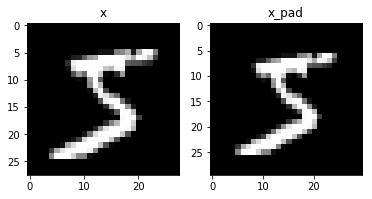

In [14]:
x_pad = padding(x_train[0], 1)
print ("x.shape =", x_train[0].shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x_train[1])
print ("x_pad[1,1] =", x_pad[1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x_train[0,:,:], cmap='gray')
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[:,:], cmap='gray')

The 'x_pad' image looks kind of zoomed out than the original image 'x', this is due to the zero padding that adds more pixel density to the image

Now let's implement it in the Convolution2D class

In [39]:
class Convolution2D:
    def __init__(self, filter_shape, num_filters, padding, stride, debugging=False):
        self.filter_shape = filter_shape
        self.num_filters = num_filters
        self.padding = padding
        self.stride = stride
        self.filters = np.random.randn(num_filters, filter_shape[0], filter_shape[0]) # random initialization
        self.debugging = debugging
        
    def iterate(self, img, filter_shape):
        height, width = img.shape
        height = int((height + 2 * self.pad_size - self.filter_shape[0]) / self.stride) + 1
        width = int((width + 2 * self.pad_size - self.filter_shape[0]) / self.stride) + 1
        # check for odd heights and widths
        if height % 2 != 0 and width % 2 != 0:
            height += 1
            width += 1
#         print(height)
#         print(width)
#         print(filter_shape[0]-1)
        
        for i in range(height-(filter_shape[0]-1)):
            for j in range(width-(filter_shape[0]-1)):
#                 i_start = i * self.stride
#                 i_end = i_start + filter_shape[0]
#                 j_start = j * self.stride
#                 j_end = j_start * filter_shape[0]
#                 output = img[i_start:i_end, j_start:j_end]
                output = img[i*self.stride:(i*self.stride+filter_shape[0]), j*self.stride:(j*self.stride+filter_shape[0])]
#                 print(output, i, j)
                yield output, i, j # 'yield' keyword will return any values and continue from the last value returned
    
    def conv2d(self, inputs):
        if self.debugging==True: print("Before padding: ", inputs.shape)
    
        # padding
        if(self.padding.lower() == 'same'): # same padding
            height, width = inputs.shape
            
            pad_size = int(((height * self.stride) - height + self.filter_shape[0] - 1) / 2)
            self.pad_size = pad_size

            inputs = padding(inputs, pad_size) # apply padding according to the pad_size
            height, width = inputs.shape # reinitialize height and width with padded image

            new_height = int((height + 2 * pad_size - self.filter_shape[0]) / self.stride) + 1
            new_width = int((width + 2 * pad_size - self.filter_shape[0]) / self.stride) + 1
            # check for odd heights and widths
            if new_height % 2 != 0 and new_width % 2 != 0:
                new_height += 1
                new_width += 1
                
            output = np.zeros((new_height, new_width, self.num_filters))
            
        elif(self.padding.lower() == 'valid'): # valid/no padding
            height, width = inputs.shape
            self.pad_size = 0
            output = np.zeros((height-(self.filter_shape[0]-1), width-(self.filter_shape[0]-1), self.num_filters))
            
        if self.debugging==True: print("After padding: ", inputs.shape)
        
        for region, i, j in self.iterate(inputs, self.filter_shape):
            output[i, j] = np.sum(region * self.filters, axis=(1,2))
        
        if self.debugging==True: print("After convolution: ", output.shape)
        return output

### With Padding

In [40]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

convolution = Convolution2D(filter_shape=(5,5), num_filters=8, padding='same', stride=1, debugging=True)
output = convolution.conv2d(x_train[0]) # x_train = nxn shape
output.shape # output should be the same after convolution

Before padding:  (28, 28)
After padding:  (32, 32)
After convolution:  (32, 32, 8)


(32, 32, 8)

### Without Padding

In [26]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

convolution = Convolution2D(filter_shape=(6,6), num_filters=8, stride=1, padding='valid')
output = convolution.conv2d(x_train[0]) # x_train = nxn shape
output.shape # output should be nxn because of padding

Before padding:  (28, 28)
After padding:  (28, 28)
After convolution:  (23, 23, 8)


(23, 23, 8)

Great! Now we can use padding by adding a parameter "padding" when calling the Convolution2D class

## Part 5 - Back Propagation (Softmax)

As we have seen before when we tried to train a model that only has forward propagation, it did not perform well as it did not learn anything from the training phase. This is because our model only knows how to calculate and output predictions without the ability to trace back (calculating gradients and update weights & biases).

![BackpropURL](https://miro.medium.com/max/1742/1*FceBJSJ7j8jHjb4TmLV0Ew.png "Backpropagation with its derivative")

From the illustration above, backpropagation starts from the very last layer of our convolutional model, which is the softmax layer. The gradient is simply the partial derivation from loss over the partial derivation from the activation function from previous layer

\begin{equation*}
\frac{\partial L}{\partial z} = 0 if {i \neq c}
\end{equation*}

\begin{equation*}
\frac{\partial L}{\partial z} = \frac{-1}{p_i} if {i = c}
\end{equation*}

The partial derivation of this equation is simple:
1. 0 if the prediction is not the same with the label
2. -1/pi if the prediction is the same as the label

Now we have completed the Softmax backpropagation phase. Now, let's calculate the gradient from activation function z.<br>
<br>Recall that Softmax activation function is
\begin{equation*}
S = {\sum_{i} e^{t_i}}
\end{equation*}

\begin{equation*}
z = \frac{e^{x_i}} {\sum_{j=1}^n e^{x_j}}
\end{equation*}

We can substitute the denominator in z
\begin{equation*}
z = \frac{e^{x_i}} {S} = {e^{x_i}} {S^{-1}}
\end{equation*}

Apply the chain rule to obtain the derivative
\begin{equation*}
\frac{\partial z}{\partial {t_k}} = \frac{{-e^{t_c}}{e^{t_k}}}{S^2} 
\end{equation*}
\begin{equation*}
\frac{\partial z}{\partial t_c} = \frac{{e^{t_c}}{(S - e^{t_c})}}{S^2} 
\end{equation*}

Alright, let's implement them in the code!

In [27]:
class Softmax:
    # initialize random weights and zero biases
    def __init__(self, num_features, num_nodes):
        self.weights = np.random.randn(num_features, num_nodes) / num_features
        self.biases = np.zeros(num_nodes)
#         print(self.weights.shape)
#         print(self.biases.shape)
    
    # move flatten inside the dense function
#     def flatten(self, inputs):
#         self.inputs = inputs.flatten()
#         print(self.inputs.shape)
    
    # connects flattened layer with a fully connected layer (dense)
    def dense(self, inputs):
        self.last_input_shape = inputs.shape # cache the last input shape BEFORE FLATTENING
        
        inputs = inputs.flatten()
        self.last_input = inputs # cache the last input shape AFTER FLATTENING
        input_features, nodes = self.weights.shape
        
        z = np.dot(inputs, self.weights) + self.biases # z = W . X + b
        self.z = z # cache z for backpropagation
        a = np.exp(z) # a = g(z)
        
        return a / np.sum(a, axis=0) # e^a / sum(a)
    
    def back_propagation(self, dL, learning_rate):
        for i, grad in enumerate(dL):
            if grad == 0: continue; # ignores 0 gradient
            
            exp_total = np.exp(self.z) # total of e^
            exp_sum = np.sum(exp_total) # sum of e^
            
            # gradients of z against totals
            dz = -exp_total[i] * exp_total / (exp_sum ** 2)
            dz[i] = exp_total[i] * (exp_sum - exp_total[i]) / (exp_sum ** 2)
            
            # gradients of totals against weights, biases, inputs
            dt_dw = self.last_input
            dt_db = 1
            dt_di = self.weights
            
            # gradients of loss against totals
            dL_dt = grad * dz
            
            # gradients of loss against weights, biases, and inputs
            dL_dw = np.dot(dt_dw[np.newaxis].T, dL_dt[np.newaxis])
            dL_db = dL_dt * dt_db
            dL_di = np.dot(dt_di, dL_dt)
            
            # update weights and biases
            self.weights -= learning_rate * dL_dw
            self.biases -= learning_rate * dL_db
            
            return dL_di.reshape(self.last_input_shape)

In [28]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [42]:
convolution = Convolution2D(filter_shape=(3,3), num_filters=8, padding='same', stride=1)
maxpool = MaxPool2D()
softmax = Softmax(15*15*8, 10)

In [43]:
def forward_propagation(img, label):
    output = convolution.conv2d(img/255)
    output = maxpool.pool(output)
#     output = softmax.flatten(output)
    output = softmax.dense(output)
    
    loss = -np.log(output[label]) # -log(x) --> softmax loss function
    acc = 1 if np.argmax(output) == label else 0 # increase the accuracy if the predicted label = actual label
    
    return output, loss, acc

In [44]:
def train(img, label, learning_rate):
    # forward propagation
    output, loss, acc = forward_propagation(img, label)
    
    # initial gradient
    grad = np.zeros(10) # 10 different classes
    grad[label] = -1 / output[label]
    
    # back propagation
    grad = softmax.back_propagation(grad, learning_rate)
    
    return loss, acc

In [45]:
l = 0
acc = 0

for i, (img, label) in enumerate(zip(x_train[:1000], y_train[:1000])):
    if i % 100 == 0:
        print("Epoch #%d: Loss=%.3f | Accuracy=%.2f%%" % (i, l/100, acc))
        l = 0
        acc = 0
    loss, accuracy = train(img, label, learning_rate=0.005)
    l += loss
    acc += accuracy

Epoch #0: Loss=0.000 | Accuracy=0.00%
Epoch #100: Loss=2.357 | Accuracy=43.00%
Epoch #200: Loss=1.320 | Accuracy=68.00%
Epoch #300: Loss=1.313 | Accuracy=70.00%
Epoch #400: Loss=0.948 | Accuracy=75.00%
Epoch #500: Loss=0.817 | Accuracy=78.00%
Epoch #600: Loss=1.274 | Accuracy=73.00%
Epoch #700: Loss=1.341 | Accuracy=77.00%
Epoch #800: Loss=0.750 | Accuracy=79.00%
Epoch #900: Loss=1.624 | Accuracy=73.00%


Great it's working! Now you can see that the accuracy is gradually increasing each epoch. But this is still incomplete because we only backpropagate through the Softmax layer, we also have to backpropagate through the MaxPooling and Convolution2D layer

## Part 6 - Back Propagation (MaxPool & Conv2D)

In the forward propagation phase, pooling layer halves the dimension by extracting a maximum value over 2x2 blocks. Now backpropagation does the opposite: <b>double the dimension of the loss gradient by assigning each gradient value to where the original max value was</b> in its 2x2 block

![PoolBackpropURL](https://victorzhou.com/media/cnn-post/maxpool-forward.svg "2x2 MaxPooling Backpropagation")
Image taken from: https://victorzhou.com/blog/intro-to-cnns-part-2/

In [56]:
class MaxPool2D:
    def iterate(self, img):
        height, width, _ = img.shape
        h = height//2
        w = width//2
        
        for i in range(h):
            for j in range(w):
                new_region = img[(i*2):(i*2+2), (j*2):(j*2+2)]
                yield new_region, i, j
    
    # 2x2 maxpool --> nxn maxpool if possible
    def pool(self, inputs):
        self.last_input = inputs # cache last input for backpropagation
        
        height, width, num_filters = inputs.shape
        output = np.zeros((height//2, width//2, num_filters))
        
        for img_region, i, j in self.iterate(inputs):
            output[i, j] = np.max(img_region, axis=(0,1))
        
        return output
    
    def back_propagation(self, dL_output):
        dL_input = np.zeros((self.last_input.shape))
        
        for img_region, i, j in self.iterate(self.last_input):
            height, width, num_filters = img_region.shape
            # find the max value for each region
            maxi = np.max(img_region, axis=(0,1))
            
            for k in range(height):
                for l in range(width):
                    for m in range(num_filters):
                        if img_region[k, l, m] == maxi[m]: # if the max values match, copy the gradient
                            dL_input[i*2+k, j*2+l, m] = dL_output[i, j, m]
        return dL_input

For backpropagation on Convolution 2D, we are only interested in <b>the loss gradient for the filters in the convolutional layers</b> to update filter weights and biases.

In [57]:
class Convolution2D:
    def __init__(self, filter_shape, num_filters):
        self.filter_shape = filter_shape
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, filter_shape[0], filter_shape[0]) # random initialization
        
    def iterate(self, img, filter_shape):
        height, width = img.shape
        
        for i in range(height - 2):
            for j in range(width - 2):
                output = img[i:(i+filter_shape[0]), j:(j+filter_shape[0])]
                yield output, i, j # 'yield' keyword will return any values and continue from the last value returned
    
    def conv2d(self, inputs):
        self.last_input = inputs # cache the last input for backpropagation
        
        height, width = inputs.shape
        output = np.zeros((height-2, width-2, self.num_filters)) 
        
        for region, i, j in self.iterate(inputs, self.filter_shape):
            output[i, j] = np.sum(region * self.filters, axis=(1,2))
#             print(region * self.filters)
        
        return output
    
    def back_propagation(self, dL, learning_rate):
        dL_filters = np.zeros(self.filters.shape)
        
        for img_region, i, j in self.iterate(self.last_input, self.filter_shape):
            for k in range(self.num_filters):
                dL_filters[k] += dL[i, j, k] * img_region
        
        # don't forget to update the filters
        self.filters -= learning_rate * dL_filters
        
        return None

## Part 7 - Putting it altogether

Now the basic construction for our model is complete! Let's put them together

In [75]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [76]:
conv = Convolution2D(num_filters=8, filter_shape=(3,3))
pooling = MaxPool2D()
softmax = Softmax(13*13*8, 10)

In [77]:
def forward_propagation(img, label):
    # define the model
    model = conv.conv2d(img/255)
    model = pooling.pool(model)
    model = softmax.dense(model)
    
    # calculate loss
    loss = -np.log(model[label])
    acc = 1 if np.argmax(model) == label else 0
    
    return model, loss, acc

In [78]:
def train(img, label, learning_rate=0.005):
    # forward propagation
    output, loss, acc = forward_propagation(img, label) # test with 1000 images
    # initial gradient
    grad = np.zeros(10)
    grad[label] = -1 / output[label]
    # back propagation
    grad = softmax.back_propagation(grad, learning_rate)
#     print(grad.shape)
    grad = pooling.back_propagation(grad)
    grad = conv.back_propagation(grad, learning_rate)
    
    return loss, acc

In [79]:
# train the model
for epoch in range(3):
    print("EPOCH #", epoch)
    
    loss = 0
    accuracy = 0
    for i, (img, label) in enumerate(zip(x_train[:1000], y_train[:1000])):
        if i % 100 == 0:
            print("Step #%d: Loss=%.3f | Accuracy=%d %%" % (i, loss/100, accuracy))
            loss = 0
            accuracy = 0
            
        l, acc = train(img, label)
        loss += l
        accuracy += acc

EPOCH # 0
Step #0: Loss=0.000 | Accuracy=0 %
Step #100: Loss=1.950 | Accuracy=45 %
Step #200: Loss=1.168 | Accuracy=67 %
Step #300: Loss=0.956 | Accuracy=71 %
Step #400: Loss=0.709 | Accuracy=81 %
Step #500: Loss=0.613 | Accuracy=81 %
Step #600: Loss=0.902 | Accuracy=75 %
Step #700: Loss=0.859 | Accuracy=80 %
Step #800: Loss=0.507 | Accuracy=84 %
Step #900: Loss=0.894 | Accuracy=80 %
EPOCH # 1
Step #0: Loss=0.000 | Accuracy=0 %
Step #100: Loss=0.360 | Accuracy=89 %
Step #200: Loss=0.454 | Accuracy=86 %
Step #300: Loss=0.490 | Accuracy=85 %
Step #400: Loss=0.235 | Accuracy=93 %
Step #500: Loss=0.346 | Accuracy=87 %
Step #600: Loss=0.337 | Accuracy=90 %
Step #700: Loss=0.405 | Accuracy=86 %
Step #800: Loss=0.282 | Accuracy=92 %
Step #900: Loss=0.395 | Accuracy=88 %
EPOCH # 2
Step #0: Loss=0.000 | Accuracy=0 %
Step #100: Loss=0.198 | Accuracy=95 %
Step #200: Loss=0.188 | Accuracy=93 %
Step #300: Loss=0.303 | Accuracy=90 %
Step #400: Loss=0.091 | Accuracy=99 %
Step #500: Loss=0.202 | Accur

In [83]:
# test the model
loss = 0
accuracy = 0
for img, label in zip(x_test[:1000], y_test[:1000]):
    _, l, acc = forward_propagation(img, label)
    loss += l
    accuracy += acc
            
print("Test Loss: ", loss/len(x_test[:1000]))
print("Test Accuracy: ", accuracy/len(x_test[:1000])* 100, '%')

Test Loss:  0.6366723476818364
Test Accuracy:  81.39999999999999 %


## Part 8 - Keras Model

Let's compare our model with keras built-in library model

In [84]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.utils import to_categorical
from keras import optimizers

Using TensorFlow backend.


In [85]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [86]:
# normalization
x_train = x_train/255
x_test = x_test/255

# reshape
x_train = np.reshape(x_train, ((60000,28,28,1)))
x_test = np.reshape(x_test, (10000,28, 28,1))

# one-hot encoding for label y
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [87]:
y_test.shape

(10000, 10)

In [88]:
# create the model with the same hyperparameters as the scratch model
keras_model = Sequential()
keras_model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', input_shape=(28,28,1)))
keras_model.add(MaxPool2D(pool_size=2))

keras_model.add(Flatten())
keras_model.add(Dense(10, activation='softmax'))

opt = optimizers.SGD(lr=0.01)
keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) # optimizer is not yet implemented
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                15690     
Total params: 15,770
Trainable params: 15,770
Non-trainable params: 0
_________________________________________________________________


In [89]:
history = keras_model.fit(x_train[:1000], y_train[:1000], validation_split=0.33, batch_size=1, epochs=3)

Train on 669 samples, validate on 331 samples
Epoch 1/3
669/669 [==============================] - 6s 9ms/step - loss: 1.2066 - acc: 0.6054 - val_loss: 0.6571 - val_acc: 0.7946
Epoch 2/3
669/669 [==============================] - 5s 8ms/step - loss: 0.4856 - acc: 0.8460 - val_loss: 0.5887 - val_acc: 0.8338
Epoch 3/3
669/669 [==============================] - 6s 10ms/step - loss: 0.3171 - acc: 0.8969 - val_loss: 0.6336 - val_acc: 0.8248


In [90]:
keras_model.evaluate(x_test[:1000], y_test[:1000])

1000/1000 [==============================] - 0s 273us/step


[0.5380505723953247, 0.822]

Not bad! It is similar with our scratch model achieving ~80% accuracy on the test set